<a href="https://colab.research.google.com/github/Ha-eunYu/pix2pix/blob/main/pix2pix_230112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os #os임포트
import random #random임포트
import torch 
import torchvision
import torch.nn as nn
from torch.backends import cudnn
from torch import optim
from torch.autograd import Variable
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets.folder import default_loader
import torch.nn.functional as F #~pytorch임포트
import numpy as np #numpy임포트
from PIL import Image #PIL에서 image임포트
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg #~matplotlib임포트
# from network import *
from skimage.color import lab2rgb, rgb2lab, rgb2gray #skimage임포트
from skimage import io

use_gpu = torch.cuda.is_available() #GPU사용 유무

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
global args_tmp #전역으로 사용되는 변수 지정
args_tmp={}
args_tmp['dataroot'] = paths
# 'data/256_resize' #데이터셋 경로

args_tmp['num_epochs'] = 100 #epoch수
args_tmp['batchSize'] = 8 #batch크기
args_tmp['lr'] = 0.0002 #학습률
args_tmp['beta1'] = 0.5
args_tmp['beta2'] = 0.999 #~adam에 사용되는 모멘텀 변수
args_tmp['lambda_A'] = 100.0 #L1항 계수

args_tmp['model_path'] = './models' #모델 경로
args_tmp['sample_path'] = './results' #샘플 경로
args_tmp['log_step'] = 10 #10번마다 log찍기
args_tmp['sample_step'] = 100  #100번마다 샘플 뽑기
args_tmp['num_workers'] = 2 #dataloader worker수


In [ ]:
from fastai.data.external import untar_data,URLs
import glob

coco_path = untar_data(URLs.COCO_SAMPLE)
paths = glob.glob(str(coco_path) + "/train_sample/*.jpg")


In [ ]:
import numpy as np

np.random.seed(1)
chosen_paths = np.random.choice(paths, 5000, replace=False)
index = np.random.permutation(5000)

train_paths = chosen_paths[index[:4000]] # 앞의 4000을 train 이미지 쓰겠다.
val_paths = chosen_paths[index[4000:]]

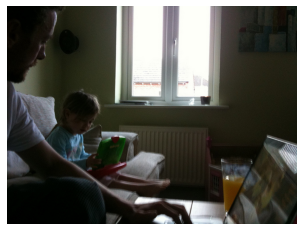

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

sample = matplotlib.image.imread(train_paths[2])
plt.imshow(sample)
plt.axis("off")
plt.show()

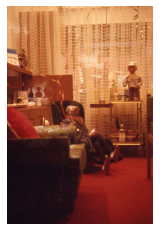

In [ ]:
sample = matplotlib.image.imread(val_paths[2])
plt.imshow(sample)
plt.axis("off")
plt.show()

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
import numpy as np

class ColorizationDataset(Dataset):
  def __init__(self, paths, mode='train'):
      self.mode = mode
      self.paths = paths
      # if else문으로 mode가 train  or val?
      if mode == "train":
      # trasform.Compose 선언!
      # train인 경우, 이미지 사이즈 통일하고 random horizontal flip으로 augmentation
      # MS COCO 가 이미지가 작아서 512는 무리
        self.transforms = transforms.Compose([
            transforms.Resize((256, 256), Image.BICUBIC),
            transforms.RandomHorizontalFlip(),
        ])
      elif mode == "val":
      # validation인 경우, 이미지 사이즈만 통일하자
        self.transforms = transforms.Resize((256, 256), Image.BICUBIC)
      else:
        raise Exception("train or validation only!!!!")

  def __getitem__(self, index):
      # 이미지를 불러온다.
      img = Image.open(self.paths[index]).convert("RGB")
      # 이미지를 위에서 생성한 transform
      # 이미지를 넘파이 어레이로 변환
      img = np.array(self.transforms(img))
      target = torch.from_numpy(img.transpose((2, 0, 1))).float() #채널수를 뒤로 뺌
      # RGB 채널을 Lab 채널로 변환
      img = rgb2lab(img).astype("float32") 
      # 이미지를 텐서로 변환
      img = transforms.ToTensor()(img)
      L = img[[0], ...] /50. -1 # -1 ~ 1 사이로 정규화를 진행한다.
      ab = img[[1, 2], ...] / 110. # -1 ~ 1 사이로 정규화를 진행한다.


      return {'L': L, 'ab': ab, 'img':img}

  def __len__(self):
      return len(self.paths)

In [ ]:
dataset_train = ColorizationDataset(train_paths, mode='train')
dataset_val = ColorizationDataset(val_paths, mode='val')

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size=16, num_workers=2, pin_memory=True)
dataloader_val = DataLoader(dataset_val, batch_size=16, num_workers=2, pin_memory=True)

In [ ]:
# 첫번째 iteration에서 나오는 데이터 확인
data = next(iter(dataloader_train))
Ls, abs, img= data['L'],data['ab'],data['img']
print(Ls.shape, abs.shape, img.shape)

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256]) torch.Size([16, 3, 256, 256])


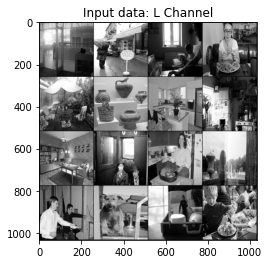

In [ ]:
import torchvision
grid = torchvision.utils.make_grid(Ls,nrow=4,normalize=True)
plt.imshow(grid.permute(1,2,0))
plt.title("Input data: L Channel")
plt.show()

In [ ]:
100/50. -1

1.0

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.input_layer = nn.Sequential(
        # 너비와 높이가 2배씩 증가
        # input_channels: L channel 
        nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    ) # L channels [1*256*256] -> [64*128*128]

    self.encoder_1 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True), # [128*64*64]
        nn.BatchNorm2d(128)
    )

    self.encoder_2 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=True), # [256*32*32]
        nn.BatchNorm2d(256)
    )

    self.encoder_3 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=True), # [512*16*16]
        nn.BatchNorm2d(512)
    )

    self.encoder_4 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=True),# [512*8*8]
        nn.BatchNorm2d(512)
    )

    self.encoder_5 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=True), # [512*4*4]
        nn.BatchNorm2d(512)
    )

    self.encoder_6 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=True), # [512*2*2]
        nn.BatchNorm2d(512)
    )

    self.middle = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False), # [512*1*1]
        nn.ReLU(True),
        nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False), # [512*2*2]
        nn.BatchNorm2d(512)
    )

    self.decoder_6 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False), # [(512+512)*2*2] -> [512*4*4]
        nn.BatchNorm2d(512),
        nn.Dropout(0.5)
    )

    self.decoder_5 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False), # [(512+512)*4*4] -> [512*8*8]
        nn.BatchNorm2d(512),
        nn.Dropout(0.5)
    )

    self.decoder_4 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False), # [(512+512)*8*8] -> [512*16*16]
        nn.BatchNorm2d(512),
        nn.Dropout(0.5)
    )

    self.decoder_3 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1, bias=False), # [(512+512)*16*16] -> [256*32*32] 
        nn.BatchNorm2d(256),
        nn.Dropout(0.5)
    )

    self.decoder_2 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1, bias=False), # [(256+256)*32*32] -> [128*64*64]
        nn.BatchNorm2d(128),
        nn.Dropout(0.5)
    )

    self.decoder_1 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1, bias=False), # [(128+128)*64*64] -> [64*128*128]
        nn.BatchNorm2d(64),
        nn.Dropout(0.5)
    )

    # output_channel: a channel, b channel
    # cat_1까지 cat skip conection
    self.output_layer = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1),
        nn.Tanh()
    )
    


  def forward(self, x):
    input_layer = self.input_layer(x)
    
    encoder_1 = self.encoder_1(input_layer)
    encoder_2 = self.encoder_2(encoder_1)
    encoder_3 = self.encoder_3(encoder_2)
    encoder_4 = self.encoder_4(encoder_3)
    encoder_5 = self.encoder_5(encoder_4)
    encoder_6 = self.encoder_6(encoder_5)
    
    middle = self.middle(encoder_6)

    cat_6 = torch.cat((middle, encoder_6), dim=1)
    decoder_6 = self.decoder_6(cat_6)
    cat_5 = torch.cat((decoder_6, encoder_5), dim=1)
    decoder_5 = self.decoder_5(cat_5)
    cat_4 = torch.cat((decoder_5, encoder_4), dim=1)
    decoder_4 = self.decoder_4(cat_4)
    cat_3 = torch.cat((decoder_4, encoder_3), dim=1)
    decoder_3 = self.decoder_3(cat_3)
    cat_2 = torch.cat((decoder_3,encoder_2), dim=1)
    decoder_2 = self.decoder_2(cat_2)
    cat_1 = torch.cat((decoder_2, encoder_1), dim=1)
    decoder_1 = self.decoder_1(cat_1)

    output = self.output_layer(decoder_1)

    return output

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):    
    super(Discriminator, self).__init__()

    # C64 : [(2+1)x256x256] -> [64x128x128]
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, True)
        )
    # C128 : -> [128x64x64]
    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, True)
        )
    # C256 -> [256x32x32]
    self.conv3 = nn.Sequential(
        nn.Conv2d(128,256,4,2,1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, True)
        )
    # C512 -> [512x31x31]
    self.conv4 = nn.Sequential(
        nn.Conv2d(256,512,4,1,1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, True)
        )
    # C512 -> [1x30x30]
    self.conv5 = nn.Sequential(
        nn.Conv2d(512,1,4,1,1),
        # nn.BatchNorm2d(256),
        nn.Sigmoid()
        )
    


  # # ab: 실제/변환된 이미지 a & b chanel, L: 조건(condition) L_channel
  # def forward(self,ab,L):
  #   out = torch.cat((L,ab), dim=1)
  #   out = self.conv1(out)
  #   out = self.conv2(out)
  #   out = self.conv3(out)
  #   out = self.conv4(out)
  #   out = self.conv5(out)

  #   return out        

    self.conv1 = nn.Sequential(

    def forward(self,x):
      return self.model(x)
  

In [1]:
def init_weights(m):
  # layer가 컨볼루션이라면
  if type(m) == nn.Conv2d:
    # _: 같은 함수라도 덮어씌움, 없으면 새롭게 선언
    nn.init.normal_(m.weight.data,  mean=0.0, std=0.02)
    print("Conv2d Initialized!!!!!")
  # layer가 전치컨볼루션이라면
  elif type(m) == nn.ConvTranspose2d:
    nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    print('Transposed Convolution Initialized!!!!!')

  elif type(m) == nn.BachNorm2d:
    nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
    # 
    nn.init.constant(n,bias.data,0.)
    print('BatchNorm2d Initialized!!!!')

def model_initialize(model):
  model.apply(init_weights)
  return model
